In [1]:
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import STL
import numpy as np

import matplotlib.font_manager as fm
import seaborn as sns

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

from data1.serialize import SerializerSettings
from data1.small_context import get_datasets,get_memorization_datasets

In [3]:
import openai
openai.api_key = ""
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")

from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.validation_likelihood_tuning import get_autotuned_predictions_data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from models import llmtime
from models.llmtime import get_llmtime_predictions_data

In [4]:
class Stl_decomposition:
    def __init__(self, data, period=None, whether_plot=False):
        self.train_data = data[0]
        self.test_data = data[1]
        self.period = period
        self.whether_plot = whether_plot
    
    def stl_decoposition(self):
        '''
        Params:
            data: one-dimension, tuple
            period: often choose the number of days/ months/ years, seems like it can be inferred automatically
        Returns: 
            seas_data: seasonal daata
            trend_data: trend data
            resid_data: residual data
        '''
        res = STL(self.train_data, period=self.period).fit()
        if self.whether_plot:
            res.plot()
        seas_data = res.seasonal
        trend_data = res.trend
        resid_data = res.resid
        return seas_data, trend_data, resid_data
    
    def strength(self):
        seas_data, trend_data, resid_data = self.stl_decoposition()
        resid_var = np.var(resid_data, ddof = 1)
        trend_resid_var = np.var(resid_data+trend_data, ddof = 1)
        seas_resid_var = np.var(resid_data+seas_data, ddof = 1)
        trend_strength = 1-resid_var/trend_resid_var
        seas_strength = 1-resid_var/seas_resid_var
        return trend_strength, seas_strength
    

In [5]:
def plot_preds(train, test, pred_dict, model_name, ds_name):
    '''
    Plot the Model Output
    Args:
        train: train_test
        test: test_test
        pred_dict: output, dict
        model_name: model_name, used for the label
        ds_name: dataset_name, used for the label
    '''
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black') 
    plt.plot(pred, label=model_name, color='purple')
    # shade: 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')    
    plt.legend(loc='upper left')
    plt.savefig(f'{ds_name}_{model_name}_preds.pdf', format='pdf')
    
def plot_performance(x, perf, ds_name, model_name, x_label='x', y_label='Peformance'):
    '''
    Plot the Model Performance 
    Args:
        x: x
        perf: performance_index
        ds_name: dataset_name, used for the label
        model_name: model_name, used for the label
        x_label: 
        y_label: 
    '''
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    sns.lineplot(x=x, y=perf, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel(f"{x_label}", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(f"{y_label}", fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{ds_name}_{model_name}_{name}.pdf', format='pdf')

## 真实数据集上实验
### 1. Time-LLM 对于趋势和周期数据，预测更为准确

In [6]:
# 获得 period,仅考虑下面给定的数据集
def period_get(name):
    '''
    得到数据集的period
    Args: name: dataset name, string
    Returns: period: int
    '''
    period = 0
    if name == "HeartRateDataset":
        period = 144
    if name == "GasRateCO2Dataset":
        period = 39
    if name == "AirPassengersDataset":
        period = 12
    if name == "AusBeerDataset":
        period = 4
    if name == "MonthlyMilkDataset":
        period = 12
    if name == "SunspotsDataset":
        period = 12
    if name == "WineDataset":
        period = 12
    if name == "WoolyDataset":
        period = 4
    if name == "IstanbulTraffic":
        period = 24
    if name == "TurkeyPower":   # 手推出来的, 并非真实
        period = 7
    return period

In [7]:
# get darts datasets
datasets = get_datasets()
output = {}
for name, dataset in datasets.items():
    period = period_get(name=name)
    if period != 0:
        decompos = Stl_decomposition(dataset, period=period)
        strength = decompos.strength()
        output.update({name: strength})
    if name == 'AusBeerDataset':  # 得到sample output
        decompos = Stl_decomposition(dataset, period=period, whether_plot=True)    

In [8]:
# get memorization dataset, 不考虑数据集: "TSMCStock"
datasets = get_memorization_datasets()
for name, dataset in datasets.items():
    period = period_get(name=name)
    if period != 0:
        decompos = Stl_decomposition(dataset, period=period)
        strength = decompos.strength()
        output.update({name: strength})

D:\Desktop\llmtime-main(1)\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


## 使用 Fourier Transformation 得到周期 
### 1. 当周期为全长序列时，取频域上第二高位置的频率; 最短需要有 1/4 全长序列的周期长度
### 2. 各数据集结果:
### 1) HeartRateDataset: 144
### 2) GasRateCO2Dataset: 39
### 3) TurkeyPower: 7
### 4) TSMCStock: 无论如何无周期

D:\Desktop\llmtime-main(1)\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


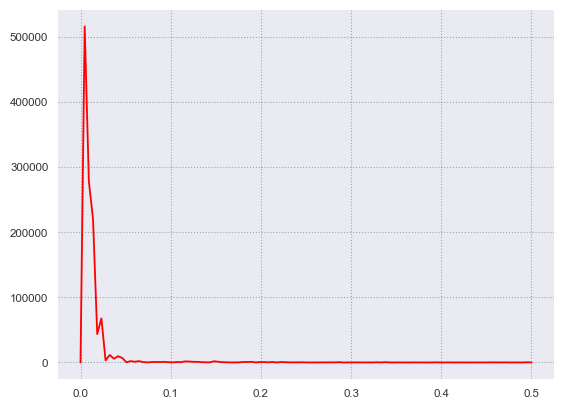

max_period 216.0
second_period 216.0
length_data 216


In [9]:
# Fourier Transformation Code
from scipy import signal

datasets = get_memorization_datasets()
data = datasets["TSMCStock"][0]
freq, pdensity = signal.periodogram(data)

fig, ax = plt.subplots()
ax.plot(freq, pdensity, color='r')
ax.grid(color='k', alpha=0.3, linestyle=':')
plt.show()
plt.close(fig)

print('max_period', 1/freq[np.argmax(pdensity)])

max_value = np.max(pdensity)
data_array = pdensity[pdensity != max_value]
print("second_period", 1/freq[np.argmax(data_array)])

print('length_data', len(data)) # 236


### Below is the working space

In [10]:
# Regression for Realdataset
# 手动将得到的结果嵌入到csv文件里了
results = pd.read_csv("Time_llm_results.csv")
results_typical = results.iloc[:6,1:]  # 有明显周期的结果, 去掉IstanbulTraffic
results_typical = results.iloc[:7,1:]  # 有明显周期的结果
results_nontypical = results.iloc[:,1:]  # 无明显周期的结果

In [11]:
# 第一张表
results

,Dataset Name,GPT4-MAPE,GPT4-R^2,GPT3.5-MAPE,GPT3.5-R^2,trend_strength,seas_strength
0,AirPassengersDataset,6.80,0.79,9.98,0.32,0.997409,0.984544
1,AusBeerDataset,3.69,0.78,5.12,0.57,0.987717,0.961134
2,MonthlyMilkDataset,5.12,0.38,6.25,-0.34,0.996473,0.993950
3,SunspotsDataset,334.30,-0.43,194.29,-1.21,0.810362,0.275599
4,WineDataset,10.90,0.49,14.98,0.11,0.672305,0.920319
5,WoolyDataset,20.41,-1.74,19.26,-1.42,0.959486,0.822665
6,IstanbulTrafficGPT,47.29,-1.96,60.11,-1.75,0.314843,0.717737
7,GasRateCO2Dataset,4.21,-0.05,5.97,-1.47,0.646014,0.503739
8,HeartRateDataset,7.90,-0.85,6.75,-0.40,0.417928,0.488174
9,TurkeyPower,3.36,0.71,3.52,0.76,0.901619,0.875574


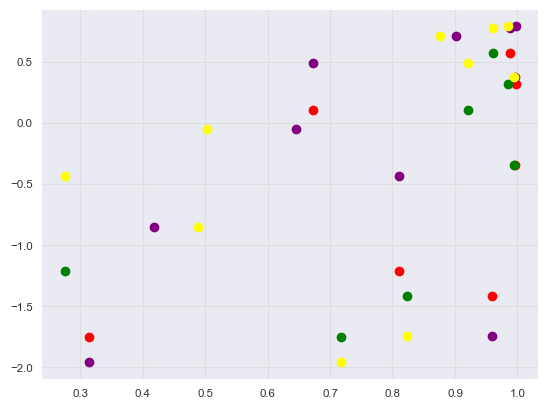

In [12]:
plt.scatter(results_typical['trend_strength'], results_typical['GPT3.5-R^2'], label='trend_strength_GPT3.5-turbo-instruct', color='red')
plt.scatter(results_typical['seas_strength'], results_typical['GPT3.5-R^2'], label='seas_strength_GPT3.5-trubo-instruct_R^2', color='green')

plt.scatter(results_nontypical['trend_strength'], results_nontypical['GPT4-R^2'], label='trend_strength_GPT4-R^2_non', color='purple')
plt.scatter(results_nontypical['seas_strength'], results_nontypical['GPT4-R^2'], label='seas_strength_GPT4-R^2_non', color='yellow')

In [13]:
correlation_matrix = results_typical.corr()
correlation_matrix  # 中等强度相关,GPT4和3.5同样
correlation_matrix_nontypical = results_nontypical.corr()
correlation_matrix_nontypical  # 中等强度相关,GPT4和3.5同样
# 采用相关系数不采用 MAPE 原因在于 MAPE 有异常值
# 相对而言，GPT-4 对于 trend 更敏感, GPT-3.5 对于周期更敏感

# 第二张表
correlation_matrix_nontypical.to_csv('correlation_matrix.csv', index=False)

### 2. 真实数据集预测结果的偏好 （是否具有趋势和周期性，并且和原来序列的趋势和周期性进行比较）

In [14]:
# 模型设定
gpt4_hypers = dict(
        alpha=0.3,
        basic=True,
        temp=1.0,
        top_p=0.8,
        settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
    )

gpt3_hypers = dict(
        temp=0.7,
        alpha=0.95,
        beta=0.3,
        basic=False,
        settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
    )

model_hypers = {
        'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
        'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    }

model_predict_fns = {
    'LLMTime GPT-4': get_llmtime_predictions_data,
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    }

In [15]:
def pred_stl(data_pred, period=None):
    '''
    Args:
        data_pred: prediction samples, ndarray, n_samples*pred_length or (pred_length,)
        period: Sometimes STL cannot recognize the period itself due to the length of the prediction steps
    Returns:
        average_pred_trend_strength: Value, float
        average_pred_seas_strength: Value, float
    '''
    if data_pred.ndim == 1:
        pred_stl = Stl_decomposition((data_pred,_), period=period)
        average_pred_trend_strength, average_pred_seas_strength = pred_stl.strength()
    else:
        iteration_num = data_pred.shape[0]
        pred_trend_strength_list = []
        pred_seas_strength_list = []  
        for i in range(iteration_num):
            pred_stl = Stl_decomposition((data_pred.iloc[i, :].values,_), period=period)
            pred_trend_strength, pred_seas_strength = pred_stl.strength()
            pred_trend_strength_list.append(pred_trend_strength)
            pred_seas_strength_list.append(pred_seas_strength)
        average_pred_trend_strength = np.average(np.array(pred_trend_strength_list))
        average_pred_seas_strength = np.average(np.array(pred_seas_strength_list))
    return average_pred_trend_strength, average_pred_seas_strength

In [16]:
datasets = get_datasets()
data = datasets['GasRateCO2Dataset']
train, test = data
test.shape

(60,)

In [17]:
model_names = list(model_predict_fns.keys())
datasets = get_datasets(testfrac=0.4)  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets_tmp = get_memorization_datasets(testfrac=0.4)  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets.update(datasets_tmp)

test_strength = {}  # 保存 test 的 strength
out_gpt_4 = {}
pred_strength_avg_4 = {}
median_pred_strength_4 = {}
out_gpt_3 = {}
pred_strength_avg_3 = {}
median_pred_strength_3 = {}

for name, dataset in datasets.items():
    period = period_get(name=name)
    if period != 0: # 保证数据集可用
        data = datasets[name]
        train, test = data
        test_strength.update({name:pred_stl(test, period=period)})
        for model in model_names: 
            model_hypers[model].update({'dataset_name': name})  # for promptcast, dict 添加元素
            hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
            num_samples = 10  # 表示重复的预测的次数       
            pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False) 
            # 依据 validation likelihood 来自动 autotune hyperparameters, 原文有如此操作 (针对可训练模型更佳)
            # 目前只关注 gpt3.5 和 gpt 4
            if model == 'LLMTime GPT-4':
                out_gpt_4.update({name: pred_dict})
                data_pred = pred_dict['samples']
                median_pred = pred_dict['median']
                pred_strength_avg_4.update({name:pred_stl(data_pred, period=period)})
                median_pred_strength_4.update({name:pred_stl(median_pred, period=period)})
            if model == 'LLMTime GPT-3.5':
                out_gpt_3.update({name: pred_dict})
                data_pred = pred_dict['samples']
                median_pred = pred_dict['median']
                pred_strength_avg_3.update({name:pred_stl(data_pred, period=period)})
                median_pred_strength_3.update({name:pred_stl(median_pred, period=period)})

D:\Desktop\llmtime-main(1)\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:19<00:00, 19.85s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:20<00:00, 20.41s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:18<00:00, 18.96s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:13<00:00, 13.15s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:11<00:00, 11.06s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'SunspotsDataset'}) 
 with NLL inf


100%|██████████| 1/1 [02:00<00:00, 120.38s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'SunspotsDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:34<00:00, 34.50s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:14<00:00, 14.23s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WoolyDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:11<00:00, 11.66s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WoolyDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'HeartRateDataset'}) 
 with NLL inf


100%|██████████| 1/1 [01:23<00:00, 83.56s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'HeartRateDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:42<00:00, 42.48s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'IstanbulTraffic'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'IstanbulTraffic'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'TurkeyPower'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'TurkeyPower'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


In [18]:
# 第三张表
columns = ['avg_trend_strength', 'avg_seasonal_strength', 'median_trend_strength', 'median_seasonal_strength', 'test_trend_strength', 'test_seasonal_strength']

df_test_str = pd.DataFrame.from_dict(test_strength, orient='index')
df_pred_str = pd.DataFrame.from_dict(pred_strength_avg_3, orient='index')
df_median_str  = pd.DataFrame.from_dict(median_pred_strength_3, orient='index')
df_str_gpt_3 = pd.concat([df_pred_str, df_median_str, df_test_str], axis=1, join='inner')
df_str_gpt_3.columns = columns
df_str_gpt_3.to_csv('strength_comparison_GPT-3.5.csv', index=False)

df_pred_str_2 = pd.DataFrame.from_dict(pred_strength_avg_4, orient='index')
df_median_str_2  = pd.DataFrame.from_dict(median_pred_strength_4, orient='index')
df_str_gpt_4 = pd.concat([df_pred_str_2, df_median_str_2, df_test_str], axis=1, join='inner')
df_str_gpt_4.columns = columns
df_str_gpt_4.to_csv('strength_comparison_GPT-4.csv', index=False)

# 此处为了尽可能增长测试集长度,采用了较小的训练集:测试集
# 对于gpt4而言,基本 trend_strength 会下降,而 seas_strength 会上升
# 对于gpt3而言,没有明显规律,甚至于基本 trend_strength 和 seas_strength 都会下降
# 注意 strength 会受到序列长度影响, 不能直接拿 traininig set 的计算结果来比较,而需要拿同等序列长度的测试集作比较
# 当输出为1时,需要注意出错,原因在于分解的周期超过了总数据长度的1/2

## 合成数据集

In [19]:
import math

In [20]:
def seas_var_computation(x_length = 20, coefficient_seas=2.0, freq=1.0):
    '''
    仅仅为了计算方便, 得到 single seas (cosx) 下的 variance
    Returns:seas_var, float
    '''
    omega = 2*np.pi*freq
    seas_var = math.pow(coefficient_seas, 2)/2*(1.0-1/math.pow(omega*x_length, 2)+1/(2*omega*x_length)*math.sin(2*omega*x_length)+1/math.pow(omega*x_length, 2)*math.cos(2*omega*x_length))
    return seas_var

def double_data_generation(data_generation):
    def wrapper(*args, **kwargs):
        freq = kwargs['freq']
        coefficient_seas = kwargs['coefficient_seas']
        x_length = kwargs['x_length']
        noise_std = kwargs['noise_std']
        coefficient_trend = kwargs['coefficient_trend']
        if type(freq) is list and type(coefficient_seas) is list:
            y = np.zeros(kwargs['num_samples'])
            omega_0 = 2*np.pi*freq[0]
            omega_1 = 2*np.pi*freq[1]
            seas_var = 0
            for freq_tmp, coefficient_seas_tmp in zip(freq, coefficient_seas):
                tmp,_ = data_generation(num_samples=kwargs['num_samples'], x_length = x_length, noise_std=noise_std/2, coefficient_trend=coefficient_trend/2, coefficient_seas=coefficient_seas_tmp, freq=freq_tmp)
                y += tmp
                seas_var += seas_var_computation(x_length = x_length, coefficient_seas = coefficient_seas_tmp, freq = freq_tmp)
            seas_var += (coefficient_seas[0]*coefficient_seas[1]/x_length*(1/(omega_0+omega_1)*math.sin((omega_0+omega_1)*x_length)+1/(omega_0-omega_1)*math.sin((omega_0-omega_1)*x_length)) - 2/math.pow(x_length,2)*math.sin(omega_0*x_length)*math.sin(omega_1*x_length)*coefficient_seas[0]*coefficient_seas[1]/omega_0/omega_1)
            trend_str = 1 - math.pow(noise_std, 2)/(1.0/12.0 * math.pow((coefficient_trend*x_length), 2) + math.pow(noise_std, 2))
            seas_str = 1 -  math.pow(noise_std, 2)/(seas_var + math.pow(noise_std, 2))
            str = (trend_str, seas_str)
        else:
            y, str = data_generation(num_samples=kwargs['num_samples'], x_length = kwargs['x_length'], noise_std=kwargs['noise_std'], coefficient_trend=kwargs['coefficient_trend'], coefficient_seas=kwargs['coefficient_seas'], freq=kwargs['freq'])
        return y, str
    return wrapper

# 原始数据生成, 这里仅考虑单周期和双周期生成，原则上讲多周期也可，只是这里代码不进行考虑
@double_data_generation
def data_generation(num_samples=200, x_length = 20, noise_std=1.0, coefficient_trend=1/4.0, coefficient_seas=2.0, freq=1.0):  # trend_type='Linear'
    '''
        Synthesized Data Generation given the cosine function y=cosx and the linear function y=x. The strength was computed based on the generation function, with the equations list below:
        trend_str =  1 - noise_std^2/(1/12 * coefficient_trend^2*x_length^2 + noise_std^2)
        seas_var = coefficient_seas^2*(1/(2*omega)*math.sin(2*omega*x_length) + 1/2*x_length)
        seas_str = 1 -  noise_std^2/(seas_var + noise_std^2)        
        startpoint = 0, period = x_length * freq
    Returns:
        y: samples, array
        zip(trend_str, seas_str)
    '''
    x = np.arange(num_samples)/num_samples*x_length
    cos_vec = np.vectorize(math.cos) # 将 function 向量化，好棒的方式
    omega = 2*np.pi*freq
    y = coefficient_trend * x + coefficient_seas*cos_vec(omega*x) + np.random.normal(0, noise_std, num_samples)
    # 粗糙计算
    trend_str =  1 - math.pow(noise_std, 2)/(1.0/12.0 * math.pow((coefficient_trend*x_length), 2) + math.pow(noise_std, 2))
    seas_var = seas_var_computation(x_length = x_length, coefficient_seas = coefficient_seas, freq = freq)
    seas_str = 1 -  math.pow(noise_std, 2)/(seas_var + math.pow(noise_std, 2))
    # 和纯数值计算计算有一定差别, 差别不大不小(0.04左右)，单调性基本可以满足; 普遍较小; n_samples越多, coeff_seas越大, 和单纯计算差别越小
    return y, (trend_str, seas_str)

# 数据分割进行预测 (testfrac=0.15)
def data_split(array, testfrac=0.15, predict_steps=30):
    if predict_steps is not None:
        splitpoint = len(array)-predict_steps
    else:    
        splitpoint = int(len(array)*(1-testfrac))
    train = array[:splitpoint]
    test = array[splitpoint:]
    return train, test

# 构建大模型预测函数
def llm_pred(model_names, name, train, test, num_samples=10):
    out = {}
    for model in model_names: 
        model_hypers[model].update({'dataset_name': name}) 
        hypers = list(grid_iter(model_hypers[model]))  
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out.update({name+'_'+model: pred_dict})
    return out

In [21]:
model_names = list(model_predict_fns.keys())

coeff_seas_array = np.arange(start=2, stop=4, step=0.2)  # 10种strength
coeff_trend_array = np.arange(start=0.2, stop=0.7, step=0.1)  # 5种strength
str_list = []
MAPE_gpt_3 = []
R_gpt_3 = []
MAPE_gpt_4 = []
R_gpt_4 = []
# num_samples=200, x_length = 20, noise_std=1.0, coefficient_trend=1/4.0, coefficient_seas=[2.0, coeff_seas], freq=[1.0, 3.0]
# 单纯计算strength有一定差别, 不大不小(0.04左右)，单调性基本可以满足; 普遍较小; n_samples越多, coeff_seas越大, 和单纯计算差别越小
seed_value = 42
np.random.seed(seed_value)

for coeff_seas in coeff_seas_array:
    for coeff_trend in coeff_trend_array:
        seed_value = 1000
        np.random.seed(seed_value)  # 控制随机数的生成
        
        y, str = data_generation(num_samples=200, x_length = 20, noise_std=1.0, coefficient_seas=coeff_seas, coefficient_trend=coeff_trend, freq=1.0)
        str_list.append(str)
        train, test = data_split(array=y, testfrac=0.15, predict_steps=None)
        out = llm_pred(model_names=model_names, name="synthesized dataset", train=train, test=test)
        # GPT 3.5
        pred = out['synthesized dataset_LLMTime GPT-3.5']["median"]
        mape = np.mean(np.abs((test - pred) / test)) * 100
        r2 = r2_score(test, pred)
        MAPE_gpt_3.append(mape)
        R_gpt_3.append(r2)
        # GPT 4
        pred = out['synthesized dataset_LLMTime GPT-4']["median"]
        mape = np.mean(np.abs((test - pred) / test)) * 100
        r2 = r2_score(test, pred)
        MAPE_gpt_4.append(mape)
        R_gpt_4.append(r2)        


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.15s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:19<00:00, 19.45s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.44s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.31s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:19<00:00, 19.62s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.74s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


In [22]:
# 第四张表
columns = ['trend_strength', 'seasonal_strength', 'R^2_GPT_3', 'R^2_GPT_4', 'MAPE_GPT_3', 'MAPE_GPT_4']

df_str = pd.DataFrame(str_list)
df_MAPE_gpt_3 = pd.DataFrame(MAPE_gpt_3)
df_MAPE_gpt_4 = pd.DataFrame(MAPE_gpt_4)
df_R_gpt_3 = pd.DataFrame(R_gpt_3)
df_R_gpt_4 = pd.DataFrame(R_gpt_4)
corr_syn = pd.concat([df_str, df_R_gpt_3, df_R_gpt_4, df_MAPE_gpt_3, df_MAPE_gpt_4], axis=1, join='outer')
corr_syn.columns = columns
correlation_matrix_syn = corr_syn.corr()
correlation_matrix_syn.to_csv('correlation_matrix_syn.csv', index=False)

### 多周期

In [23]:
# 不需要随机采样周期，在给定情况下进行处理，给出定量指标，说明定性的结论即可
# 变周期间隔同理
coeff_seas_array = np.arange(start=1.0, stop=3.0, step=0.2)  # 5种strength
coeff_trend_array = np.arange(start=0.2, stop=0.7, step=0.1)  # 5种strength
# (num_samples=200, x_length = 20, noise_std=1.0, coefficient_trend=1/4.0, coefficient_seas=2.0, freq=1.0)

model_names = list(model_predict_fns.keys())

str_list_multi = []
MAPE_gpt_3_multi = []
R_gpt_3_multi = []
MAPE_gpt_4_multi = []
R_gpt_4_multi = []

for coeff_seas in coeff_seas_array:
    for coeff_trend in coeff_trend_array:
        seed_value = 1000
        np.random.seed(seed_value)  # 控制随机数的生成
    
        y, str = data_generation(num_samples=200, x_length = 20, noise_std=1.0, coefficient_trend=coeff_trend, coefficient_seas=[2.0, coeff_seas], freq=[1.0, 3.0])
        str_list_multi.append(str)
        train, test = data_split(array=y, testfrac=0.15, predict_steps=None)
        out_multi = llm_pred(model_names=model_names, name="synthesized dataset", train=train, test=test)
        # GPT 3.5
        pred_multi = out_multi['synthesized dataset_LLMTime GPT-3.5']["median"]
        mape = np.mean(np.abs((test - pred_multi) / test)) * 100
        r2 = r2_score(test, pred_multi)
        MAPE_gpt_3_multi.append(mape)
        R_gpt_3_multi.append(r2)
        # GPT 4
        pred_multi = out_multi['synthesized dataset_LLMTime GPT-4']["median"]
        mape = np.mean(np.abs((test - pred_multi) / test)) * 100
        r2 = r2_score(test, pred_multi)
        MAPE_gpt_4_multi.append(mape)
        R_gpt_4_multi.append(r2)    


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.12s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:20<00:00, 20.40s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.57s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.06s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.99s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'synthesized dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


In [25]:
def plot_performance(x, perf, ds_name, model_name, x_label='x', y_label='Peformance'):
    '''
    Plot the Model Performance 
    Args:
        x: x
        perf: performance_index
        ds_name: dataset_name, used for the label
        model_name: model_name, used for the label
        x_label: 
        y_label: 
    '''
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    sns.lineplot(x=x, y=perf, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel(f"{x_label}", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(f"{y_label}", fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    # plt.show()
    # plt.savefig(f'{ds_name}_{model_name}_{name}.pdf', format='pdf')

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

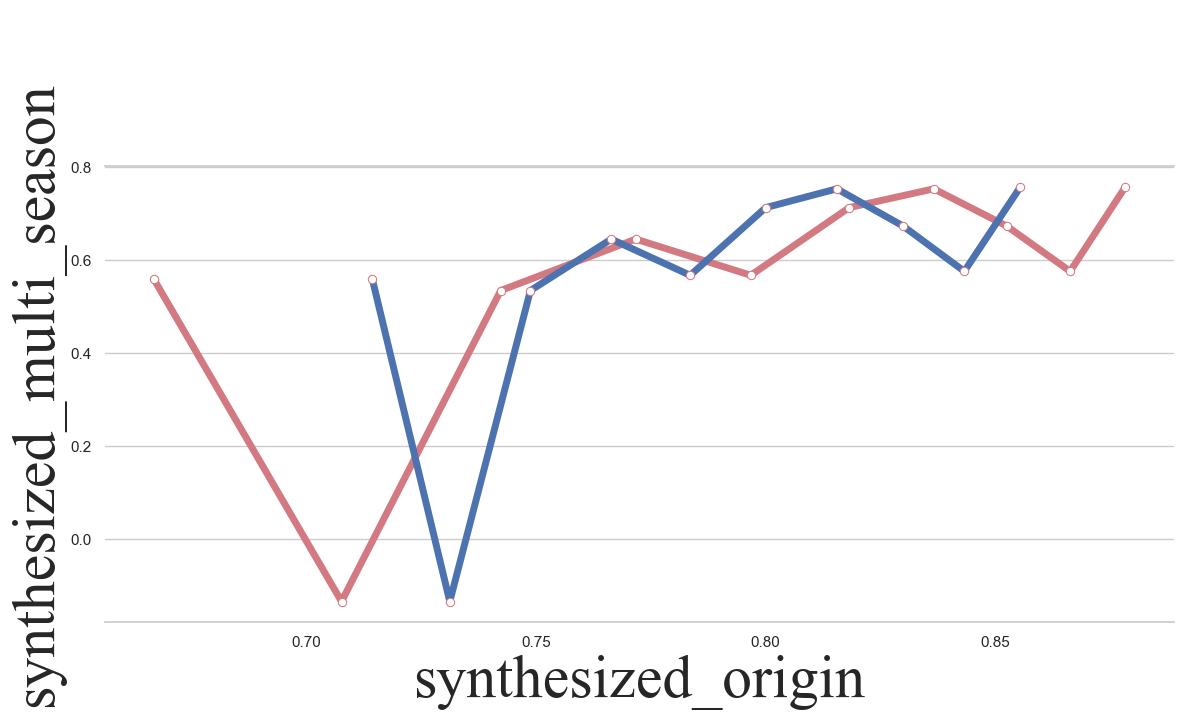

In [34]:
# 第一张图
# 比较分析; 在不进行数据预处理时的表现，追求自然的表现; 
# 针对 seas 似乎总是有 MAPE 先下降，后上升的趋势; R^2 持续上升，而后趋于平缓 (普遍上); 和自己原本预想的目标基本一致
    
str_list_mul_2 = []
str_list_2 = []
MAPE_gpt_4_2 = []
R_gpt_4_2 = []

for i in range(1, 2):  # 
    str_list_mul_2 = []
    MAPE_gpt_4_mul_2 = []
    R_gpt_4_mul_2 = []
    str_list_2 = []
    MAPE_gpt_4_2 = []
    R_gpt_4_2 = []  
    for j in range(10):
        str_list_mul_2.append(str_list_multi[i+5*j][1])
        MAPE_gpt_4_mul_2.append(MAPE_gpt_4[i+5*j])
        R_gpt_4_mul_2.append(R_gpt_4[i+5*j])        
        str_list_2.append(str_list[i+5*j][1]) 
        MAPE_gpt_4_2.append(MAPE_gpt_4[i+5*j])
        R_gpt_4_2.append(R_gpt_4[i+5*j])
    # plot_performance(x=str_list_2, perf=R_gpt_4_2, ds_name='synthesized_dataset', model_name='GPT-4', x_label='seasonal_strength',y_label='R^2')
    # plot_performance(x=str_list_mul_2, perf=R_gpt_4_mul_2, ds_name='synthesized_dataset', model_name='GPT-4', x_label='seasonal_strength',y_label='R^2')
    
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    plt.figure(figsize=(12,8))
    # plt.plot(str_list_2, R_gpt_4_2, label=f'synthesized_origin_{i}')
    # plt.plot(str_list_mul_2, R_gpt_4_mul_2, label=f'synthesized_multi_season_{i}')
    
    ax1 = plt.gca()
    sns.lineplot(x=str_list_2, y=R_gpt_4_2, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    sns.lineplot(x=str_list_mul_2, y=R_gpt_4_mul_2, alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel("synthesized_origin", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel("synthesized_multi_season", fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.savefig('Sample_multi.pdf', format='pdf')
    plt.show()
# plt.legend()
# plt.tight_layout()